# Importing required dependencies

In [1]:
import pandas as pd 
import torch
import matplotlib.pyplot as plt
from torch.nn import functional as F

# Understanding the Bigram Model


## Loading names for training the bigram language model


In [2]:
names = open('./names.txt','r').read().split('\n')
names[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
len(names)

32033

## Creating a bigram dataset

In [4]:
b = {}
for name in names[:]:
    chs = ['<S>'] + list(name) + ['<E>'] # special tokens for start and end of sentence
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        # print(f'{ch1} -> {ch2}')
        b[bigram] = b.get(bigram, 0) + 1

In [5]:
sorted(b.items(),key=lambda x: x[1], reverse=True)[:5]

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983)]

In [6]:
# dictionary to convert characters to index and vice versa
chars = sorted(list(set(''.join(names))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0 # special token for padding which indicate the start and end of the sentence
itos = {i:s for s,i in stoi.items()}

In [7]:
N = torch.zeros((27,27),dtype=torch.int32)
for name in names:
    chs = ['.'] + list(name) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1, ix2 = stoi[ch1], stoi[ch2]
        N[ix1, ix2] += 1

## Visualizing the bigram dataset

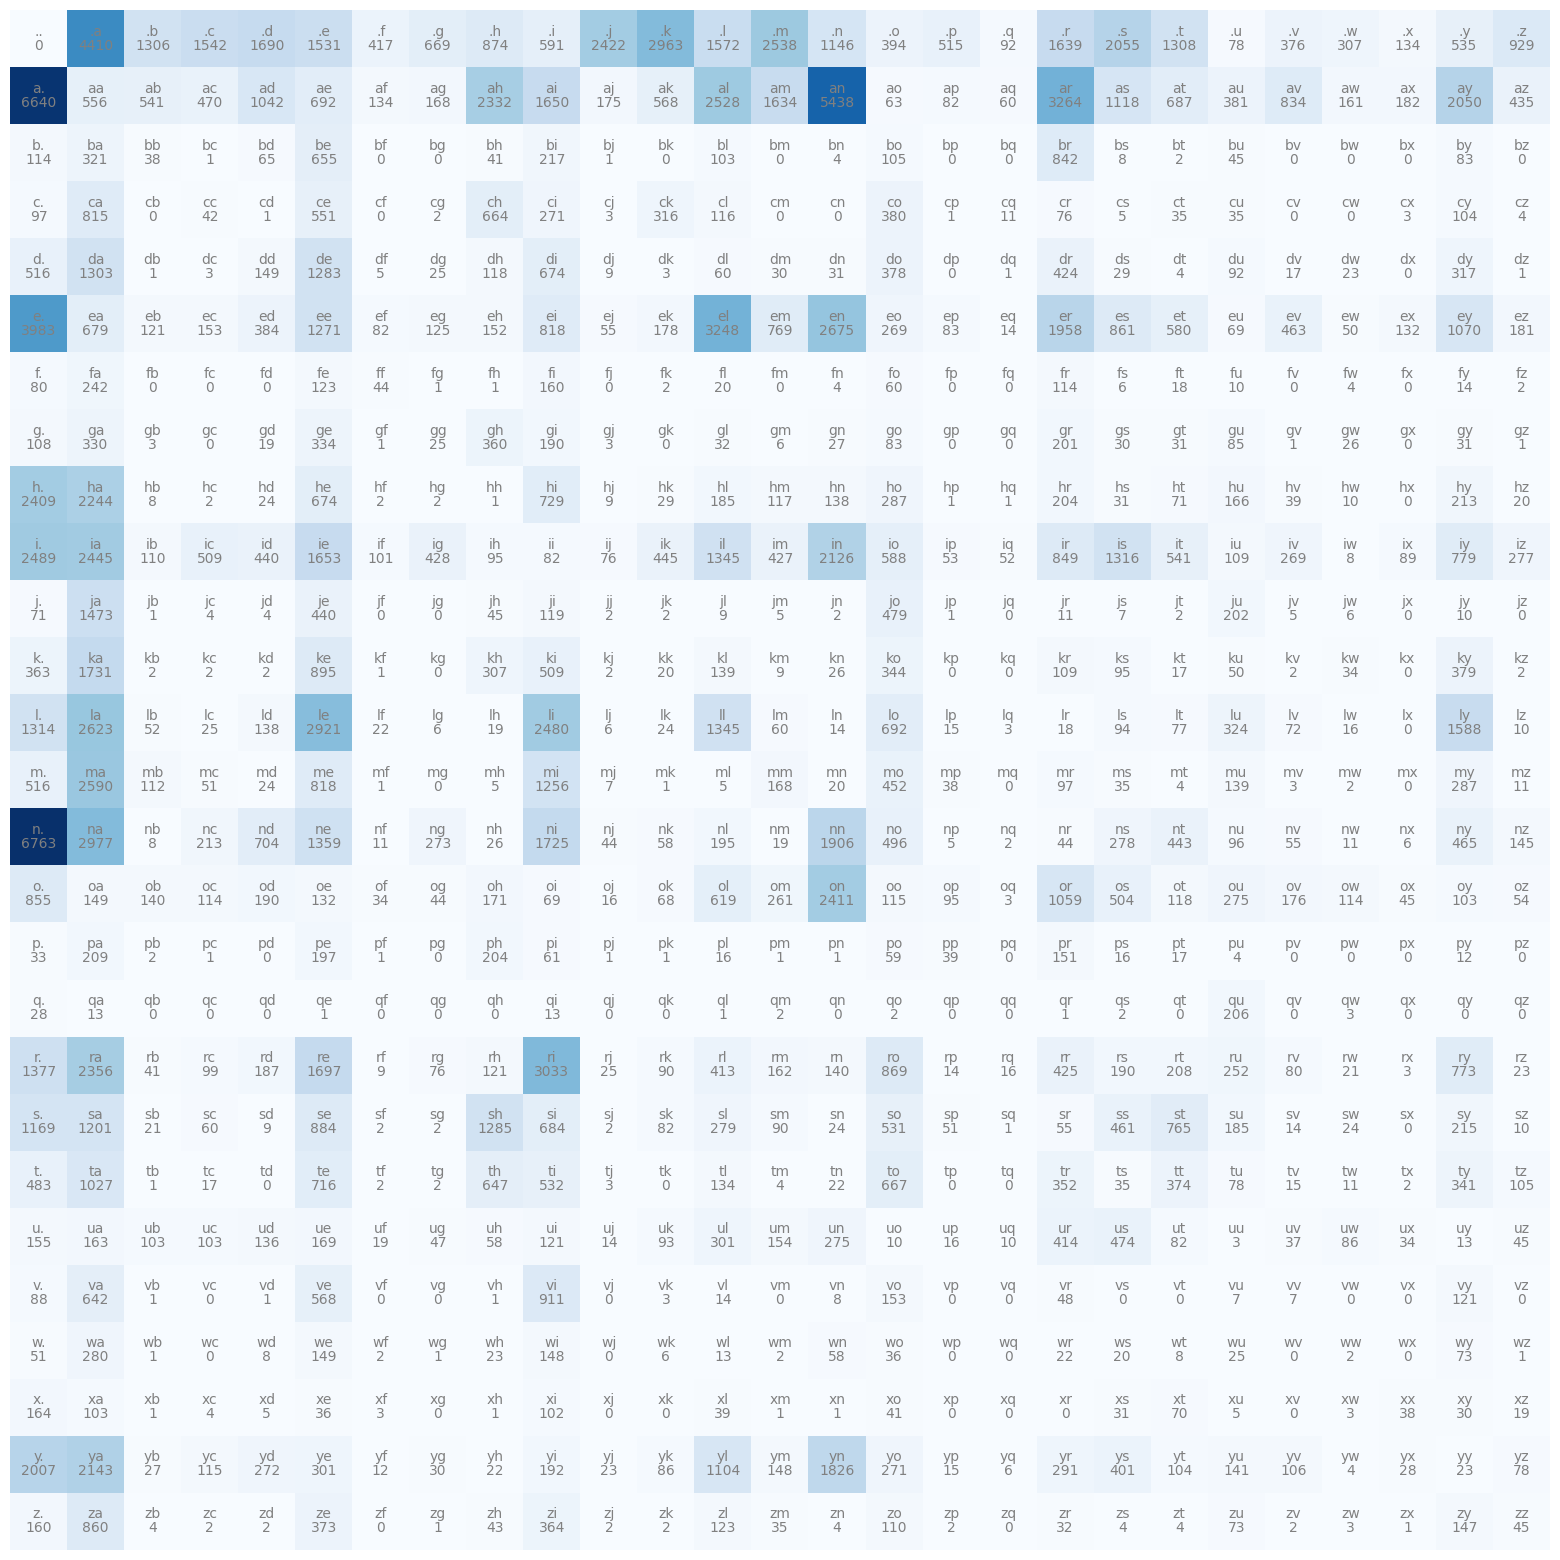

In [8]:
plt.figure(figsize=(20,20))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j,i,chstr,ha='center',va='bottom',color='gray')
        plt.text(j,i,N[i,j].item(),ha='center',va='top',color='gray')
        
plt.axis('off')
plt.show()

## Probability of each character

Example

In [9]:
p = N[0].float()
# Normalize the probabilities by dividing each element by the sum of all elements
p /= p.sum()
# Return the normalized probabilities
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [10]:
generator = torch.Generator()
ix = torch.multinomial(p, num_samples=1, replacement=True,generator=generator).item()
itos[ix]

'c'

Probs for every characters

In [11]:
P = (N+1).float() # Model smoothing
P /= P.sum(dim=1, keepdim=True)

## Sampling from the Bigram model

In [265]:
generator = torch.Generator().manual_seed(2147483647)
for i in range(10):
    ix = 0
    out = []
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True,generator=generator).item()
        if ix == 0: break
        # print(itos[ix], end='',flush=True)
        out.append(itos[ix])
    print(''.join(out))

junide
janasah
p
cony
a
nn
kohin
tolian
juee
ksahnaauranilevias


## Loss: Log-likelihood loss

In [13]:
log_likelihood = 0
n=0
for name in names[:3]:
    chs = ['.'] + list(name) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        n+=1
        ix1, ix2 = stoi[ch1], stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        print(f'{ch1}{ch2}: {prob=:.4f}  {logprob=:.4f}')
        log_likelihood += logprob
print(f'Log-likelihood: {log_likelihood.item():.4f}')
print(f'negative log-likelihood(nll): {-log_likelihood.item():.4f}')
print(f'normalized nll: {-log_likelihood/n:.4f}')

.e: prob=0.0478  logprob=-3.0410
em: prob=0.0377  logprob=-3.2793
mm: prob=0.0253  logprob=-3.6753
ma: prob=0.3885  logprob=-0.9454
a.: prob=0.1958  logprob=-1.6305
.o: prob=0.0123  logprob=-4.3965
ol: prob=0.0779  logprob=-2.5526
li: prob=0.1774  logprob=-1.7293
iv: prob=0.0152  logprob=-4.1845
vi: prob=0.3508  logprob=-1.0476
ia: prob=0.1380  logprob=-1.9807
a.: prob=0.1958  logprob=-1.6305
.a: prob=0.1376  logprob=-1.9835
av: prob=0.0246  logprob=-3.7041
va: prob=0.2473  logprob=-1.3971
a.: prob=0.1958  logprob=-1.6305
Log-likelihood: -38.8086
negative log-likelihood(nll): 38.8086
normalized nll: 2.4255


## One-hot encoding for feeding the integers into the Neural network (using only the first name: 5 bigram)

In [14]:
xs,ys = [],[]

for name in names[:1]:
    chs = ['.'] + list(name) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1, ix2 = stoi[ch1], stoi[ch2]
        # print(ch1,ch2)
        xs.append(ix1)
        ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [15]:
xs

tensor([ 0,  5, 13, 13,  1])

In [16]:
ys

tensor([ 5, 13, 13,  1,  0])

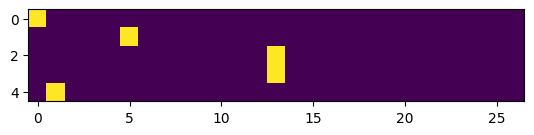

In [17]:
xenc = F.one_hot(xs, 27).float()
plt.imshow(xenc)
plt.show()

## Neural Network - one linear layer

In [18]:
W = torch.rand((27,27))
logits = xenc @ W
counts = logits.exp() 
probs = counts / counts.sum(dim=1, keepdim=True) # transforming the neural network outputs into probabilities

In [19]:
probs.shape

torch.Size([5, 27])

In [20]:
probs[0]

tensor([0.0426, 0.0299, 0.0233, 0.0382, 0.0229, 0.0229, 0.0507, 0.0563, 0.0211,
        0.0280, 0.0440, 0.0313, 0.0497, 0.0439, 0.0308, 0.0261, 0.0424, 0.0563,
        0.0547, 0.0325, 0.0425, 0.0222, 0.0472, 0.0285, 0.0566, 0.0295, 0.0258])

## Optimization

In [21]:
xs,ys

(tensor([ 0,  5, 13, 13,  1]), tensor([ 5, 13, 13,  1,  0]))

In [22]:
generator = torch.Generator()
W = torch.rand((27,27),generator=generator, requires_grad=True)

In [23]:
# Forward pass
xenc = F.one_hot(xs, 27).float()
logits = xenc @ W
counts = logits.exp()
probs = counts / counts.sum(dim=1, keepdim=True)
loss = -probs[torch.arange(5), ys].log().mean()

In [24]:
loss

tensor(3.3511, grad_fn=<NegBackward0>)

In [25]:
# Backward pass
W.grad = None
loss.backward()
W.data += W.grad * 0.1

# BIGRAM Model 

In [2]:
device = 'cpu'
seed = 2147483647
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if(device == 'cuda'):
    print(f"Using CUDA: {torch.cuda.get_device_properties(0).name}")
else:
    print("Using CPU")

Using CUDA: NVIDIA GeForce GTX 1650 Ti


In [3]:
names = open('./names.txt','r').read().split('\n')

In [4]:
# dictionary to convert characters to index and vice versa
chars = sorted(list(set(''.join(names))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0 # special token for padding which indicate the start and end of the sentence
itos = {i:s for s,i in stoi.items()}

In [6]:
xs, ys = [] , []
for name in names:
    chs = ['.'] + list(name) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        xs.append(stoi[ch1])
        ys.append(stoi[ch2])
xs = torch.tensor(xs).to(device)
ys = torch.tensor(ys).to(device)
num = len(xs)
print("Number of bigram elements:", num)

Number of bigram elements: 228146


In [15]:
# Init: neural network
Generator = torch.Generator().manual_seed(seed)
W = torch.rand((27,27),generator=Generator, requires_grad=True).to(device) # Neural network first layer weights
W_b = W.clone() # weights before training

In [33]:
# gradient descent
for _ in range(10):
    W.retain_grad()
    xenc = F.one_hot(xs, 27).float()
    logits = xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(dim=1, keepdim=True)
    loss = -probs[torch.arange(num), ys].log().mean() + W.pow(2).mean() * 0.001
    loss.backward()
    W.data += -0.01 * W.grad
    print(loss.item())

2.5096614360809326
2.509661912918091
2.509660482406616
2.5096564292907715
2.5096499919891357
2.509641408920288
2.5096309185028076
2.509617805480957
2.5096020698547363
2.509584665298462


# Sampling before training the neural net

In [36]:
generator = torch.Generator().manual_seed(seed)
for i in range(10):
    ix = 0
    out = []
    while True:
        #-----Before----------
        # p = P[ix]
        # probs = P[ix].to('cpu')

        #-----Now-----------------------
        xenc = F.one_hot(torch.tensor([ix]), 27).float().to(device)
        logits = xenc @ W_b # using the weight before training
        counts = logits.exp()
        probs = counts / counts.sum(dim=1, keepdim=True)
        probs = probs.to('cpu')

        #----------------------------------------------------------------------------------------
        ix = torch.multinomial(probs, num_samples=1, replacement=True,generator=generator).item()
        if ix == 0: break
        out.append(itos[ix])
    print(''.join(out))

juwjdvdjpkcqaz
pflfqywocbzqfsiirltohcogsjgwzzudlhnpauydbilevhajsdbduinrwimblzsnjyievylaftbzffvmumthyfoetumjrpfntszwjhrjazqycoieaysezocfpyjjabdywejfmoifmwyfvnwtgaasnhmjjihofszxhfdgosfmxtpugixz
rjpiufmthdt
rkyrmlu
iyuefyvy
mjewujcmkhvubwyhlpvhvccmagr
wdkhwfsztta
mplyisbxlhhuuiqzmumpocbzthqmimvyqwathf

sdxjxfpvslqtikyzsaloevgvvnuncewkflbjzqegruxateaxwhwtmurzsodridcdzqojjaliypvrghvxtezrwguliqqvywhqelvsviosvhibdhnceukgttmwbrscnbzoiwuvnwnpipixdewnhjgyewfdacbccxrvjypkmsbranmjrdskdotafvkdkbdeqihzzwzsqdab


# Sampling after training the neural net

In [37]:
generator = torch.Generator().manual_seed(seed)
for i in range(15):
    ix = 0
    out = []
    while True:
        #-----Before----------
        # p = P[ix]
        # probs = P[ix].to('cpu')

        #-----Now-----------------------
        xenc = F.one_hot(torch.tensor([ix]), 27).float().to(device)
        logits = xenc @ W # using the trained gradient
        counts = logits.exp()
        probs = counts / counts.sum(dim=1, keepdim=True)
        probs = probs.to('cpu')

        #----------------------------------------------------------------------------------------
        ix = torch.multinomial(probs, num_samples=1, replacement=True,generator=generator).item()
        if ix == 0: break
        out.append(itos[ix])
    print(''.join(out))

junide
janakah
pfelay
a
nn
kohin
tolera
jget
kiahetauranileviackdbdainrwi
ta
ssoninaylarte
ffveumeryfontume
pffastenaryan
reora
yaenon
